In [1]:
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

/Users/andy/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## 建立共用函數

In [2]:
# 定義weight函數
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='W')

In [3]:
# 定義bias函數
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name='b')

In [4]:
# 定義conv2d函數，卷積層
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME') # strides為濾鏡的跨步，padding為same代表超出邊界補0

In [5]:
# 定義max_poll函數，池化層
def max_poll_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # ksize為縮減取樣窗口的大小[1, height, weight, 1] 

## 建立模型

In [6]:
# 建立輸入層
with tf.name_scope('Input_Layer'): # 計算圖名稱
    x = tf.placeholder("float", shape=[None, 784], name="x")
    x_image = tf.reshape(x, [-1, 28, 28, 1]) # x原為一維向量，但要做卷積和池化必須為四維，-1代表輸入的比數不固定，28x28，1代表單色，彩色為3 

In [7]:
# 建立卷積層1 (產生多個影像)
with tf.name_scope('C1_Conv'):
    W1 = weight([5,5,1,16]) # filter weight大小為5x5，原始1個影像，產生16個影像
    b1 = bias([16])
    Conv1 = conv2d(x_image, W1) + b1 # 進行卷積運算
    C1_conv = tf.nn.relu(Conv1)

In [8]:
# 建立池化層1 (縮減取樣)
with tf.name_scope('C1_pool'):
    C1_pool = max_poll_2x2(C1_conv)

In [10]:
# 建立卷積層2
with tf.name_scope('C2_Conv'):
    W2 = weight([5,5,16,36]) # filter weight大小為5x5，16個影像，產生36個影像
    b2 = bias([36])
    Conv2 = conv2d(C1_pool, W2) + b2 # 進行卷積運算
    C2_conv = tf.nn.relu(Conv2)

In [11]:
# 建立池化層2
with tf.name_scope('C2_pool'):
    C2_pool = max_poll_2x2(C2_conv)

In [12]:
# 建立平坦層 (轉1維向量)
with tf.name_scope('D_Flat'):
    D_Flat = tf.reshape(C2_pool, [-1, 1764]) # 36x7x7 = 1764

In [13]:
# 建立隱藏層
with tf.name_scope('D_Hidden_Layer'):
    W3 = weight([1764,128]) # 輸入1764，輸出128神經元
    b3 = bias([128])
    D_Hidden = tf.nn.relu(tf.matmul(D_Flat, W3) + b3)
    D_Hidden_Dropout = tf.nn.dropout(D_Hidden, keep_prob=0.8) # 隨機去除20%神經元

In [14]:
# 建立輸出層
with tf.name_scope('Output_Layer'):
    W4 = weight([128,10])
    b4 = bias([10])
    y_predict = tf.nn.softmax(tf.matmul(D_Hidden_Dropout, W4) + b4)

## 定義訓練方式

In [15]:
with tf.name_scope('optimizer'):
    y_label = tf.placeholder('float', [None, 10], name='y_label')
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_function)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## 定義模型評估準確率

In [16]:
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_label, 1), tf.argmax(y_predict, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

## 進行訓練

In [21]:
# 定義訓練參數
from time import time
trainEpochs = 15
batchSize = 100
totalBatchs = int(mnist.train.num_examples/batchSize) # 55000/100
loss_list, epoch_list, accuracy_list = [], [], []
startTime = time()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [26]:
# 進行訓練
for epoch in range(trainEpochs): # 執行15次epoch訓練週期
    for i in range(totalBatchs):  # 每一個epoch執行550批次訓練
        batch_x, batch_y = mnist.train.next_batch(batchSize)
        sess.run(optimizer, feed_dict={x: batch_x, y_label: batch_y})
        
    loss,acc = sess.run([loss_function,accuracy], feed_dict={x: mnist.validation.images, 
                                                             y_label: mnist.validation.labels})

    epoch_list.append(epoch);loss_list.append(loss)
    accuracy_list.append(acc)    
    print("Train Epoch:", '%02d' % (epoch+1), "Loss=", "{:.9f}".format(loss)," Accuracy=",acc)
    
duration =time()-startTime
print("Train Finished takes:",duration)      

Train Epoch: 01 Loss= 1.496116042  Accuracy= 0.9688
Train Epoch: 02 Loss= 1.485624075  Accuracy= 0.9762
Train Epoch: 03 Loss= 1.480947852  Accuracy= 0.9816
Train Epoch: 04 Loss= 1.477668405  Accuracy= 0.9846
Train Epoch: 05 Loss= 1.474898219  Accuracy= 0.9874
Train Epoch: 06 Loss= 1.476185918  Accuracy= 0.9854
Train Epoch: 07 Loss= 1.473628044  Accuracy= 0.988
Train Epoch: 08 Loss= 1.475777984  Accuracy= 0.985
Train Epoch: 09 Loss= 1.473283172  Accuracy= 0.9878
Train Epoch: 10 Loss= 1.472337246  Accuracy= 0.9888
Train Epoch: 11 Loss= 1.473529935  Accuracy= 0.988
Train Epoch: 12 Loss= 1.473151207  Accuracy= 0.9878
Train Epoch: 13 Loss= 1.472974658  Accuracy= 0.9884
Train Epoch: 14 Loss= 1.475907803  Accuracy= 0.9854
Train Epoch: 15 Loss= 1.471323848  Accuracy= 0.9902
Train Finished takes: 885.7750759124756


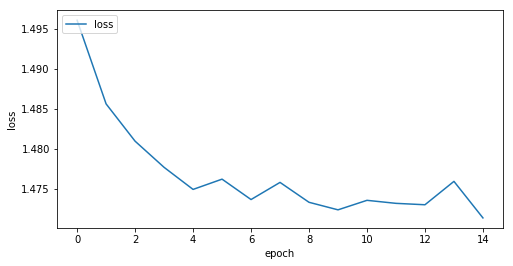

In [27]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, loss_list, label = 'loss')
plt.gcf().set_size_inches(8,4)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

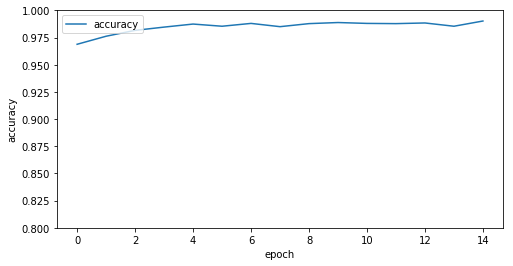

In [28]:
plt.plot(epoch_list, accuracy_list, label = 'accuracy')
plt.gcf().set_size_inches(8,4)
plt.ylim(0.8,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()

## 評估模型準確率

In [29]:
print('Accuracy', sess.run(accuracy, feed_dict={x: mnist.test.images, y_label: mnist.test.labels}))

Accuracy 0.9879


## 進行預測

In [30]:
# tf argmax將one hot encoding轉回數字0~9
prediction_result = sess.run(tf.argmax(y_predict, 1), feed_dict={x: mnist.test.images})

In [31]:
prediction_result[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [32]:
import numpy as np
def plot_images_labels_prediction(images,labels,prediction,idx,num=10): #傳入參數數字影像、真實值、預測結果、開始顯示資料、資料筆數
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25:
        num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i) #建立subgraph子圖形為5行5列
        ax.imshow(np.reshape(images[idx],(28, 28)), cmap='binary') #畫出subgraph
        title= "label=" +str(np.argmax(labels[idx])) #設定title,顯示標籤
        if len(prediction)>0:
            title+=",predict="+str(prediction[idx]) #如果有傳入預測結果，title加入預設結果
        ax.set_title(title,fontsize=10)  #設定title與大小
        ax.set_xticks([]) #不顯示刻度
        ax.set_yticks([])     
        idx+=1 #讀取下一筆
    plt.show()

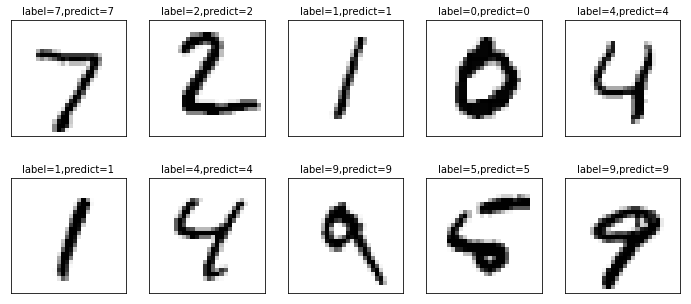

In [33]:
plot_images_labels_prediction(mnist.test.images, mnist.test.labels, prediction_result, 0)

## TensorBoard

In [34]:
# 將要顯示在TensorBoard的資料寫入log檔
tf.summary.merge_all()
train_writer = tf.summary.FileWriter('log/CNN', sess.graph)

終端機輸入tensorboard  --logdir=/Users/andy/Documents/python/校外課程\&自我學習/Tensorflow\&Keras教學/log/CNN/
<br>
瀏覽器開啟http://localhost:6006 ，點選graph即可看到圖

![title](img/CNN.png)